# Airglow data

A notebook to vizualise some of the data from B. Kenda's repositories, or data used to model airglow. 

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, interpolate, io, integrate
import obspy

from importlib import reload
import airglow_response as ar

### Collect atmospheric data
We load the known VER profile for CO2 or O2, and images of Airglow luminosity at 1.27$\mathrm{\mu}m$.

In [ ]:
reload(ar)

file1 = "./data_kenda/LUMIN_AIRGLOW_VENUS.mat"   ### Map of Venus airglow with longitude = localtime 
file2 = "./data_kenda/Radiance_4_3.mat"          ### Radiance/Luminosity at two wavelengths. Used to calculate VER 
file3 = "./data_kenda/rad28_nadir_new.mat"       ### Seems to be a VER, but not sure of the unit or calculation method ?
file4 = "./data_kenda/alpha_venus.mat"           ### Values of attenuation with frequency fo 800 points ? 
file5 = "./data_kenda/VER"                       ### Rough values of VER for 1.27 ? 

#mat1 = io.loadmat(file1)
#fig1, ax1 = plt.subplots()
#ax1.imshow(mat1["TEMP"])

mat2 = io.loadmat(file2)
mat3 = io.loadmat(file3)
# print(mat3)

### FIG 4.5 KENDA 
Limb observations of 4.28 μm and 4.32 μm on Venus’ dayside. Left panel: vertical profile for the 4.28 μm (continuous line) and 4.32 μm (dashed line) emissions. Right panel: spectral profile at 132 km (top) and 118 km (bottom) altitude. Figure from Garcia et al. (2009).

Abel transform: Goes from limb luminosity to VER (Soret et al. 2012) 
Following code is similar to code limd_to_nadir.m from KENDA 
Code starts by tapering the top of the Luminosity curve and upsampling it through interpolation. Then the integral is performed.

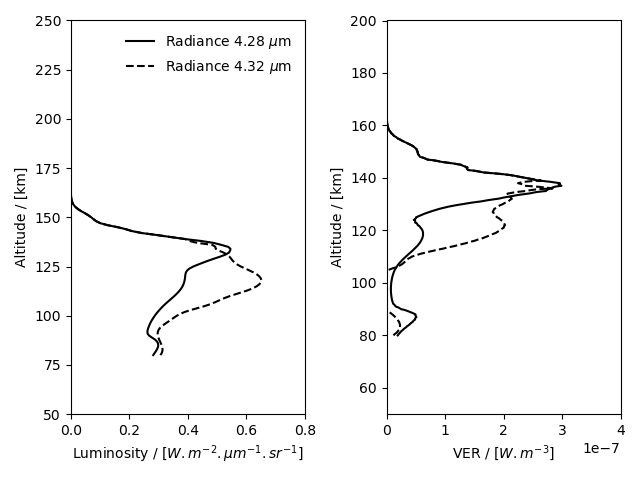

In [8]:
L28 = mat2["Rad28"][0,:]
L32 = mat2["Rad32"][0,:]
L28[71:] *= np.cos(np.linspace(0,1, 20)*np.pi/2)**2
L32[71:] *= np.cos(np.linspace(0,1, 20)*np.pi/2)**2
### Then interpolation on finer grid
LZ = np.linspace(mat2["H"][0,0], mat2["H"][0,-1], 3000)
L28 = np.interp(LZ,mat2["H"][0,:], L28 )
L32 = np.interp(LZ,mat2["H"][0,:], L32 )
### 

fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.plot(mat2["Rad28"][0,:], mat2["H"][0,:], c="k", label=r"Radiance 4.28 $\mu$m")
ax1.plot(mat2["Rad32"][0,:], mat2["H"][0,:], c="k", ls="--", label=r"Radiance 4.32 $\mu$m")
ax1.set_xlabel(r"Luminosity / [$W.m^{-2}.\mu m^{-1}. sr^{-1}$]")
ax1.set_ylabel("Altitude / [km]")
ax1.set_xlim(0.0,0.8)
ax1.set_ylim(50,250)
ax1.legend(frameon=False)

NZ = LZ.size
lambda_f = 0.03
VER_4_28 = np.zeros(NZ)
VER_4_32 = np.zeros(NZ)
d_venus = 1e3*LZ + 6052e3
DL28_dy = np.gradient(L28, d_venus[:])
DL32_dy = np.gradient(L32, d_venus[:])
for iz in range(NZ-1): 
    VER_4_28[iz] = -4 * lambda_f * integrate.trapezoid(DL28_dy[iz+1:]/np.sqrt(d_venus[iz+1:]**2-d_venus[iz]**2), x=d_venus[iz+1:])
    VER_4_32[iz] = -4 * lambda_f * integrate.trapezoid(DL32_dy[iz+1:]/np.sqrt(d_venus[iz+1:]**2-d_venus[iz]**2), x=d_venus[iz+1:])
ax2.plot(VER_4_28, LZ, c="k")
ax2.plot(VER_4_32, LZ, ls="--", c="k")
# ax2.plot(mat3["VV"][0,:]/4, mat2["H"][0,:], ls="--", c="b")   ### Not sure what this curve really is 
ax2.set_xlabel(r"VER / [$W.m^{-3}$]")
ax2.set_ylabel("Altitude / [km]")
ax2.set_xlim(0.0,4e-7)
ax2.set_ylim(50,200)
#ax2.legend(frameon=False)
fig.tight_layout()

### FIG 4.4 from Kenda 
Spatial distribution of Venus 1.27 μm airglow. (a) Lateral variations of the emission on the nightside of Venus; the x-axis is given in local time, 0 corresponds to the antisolar point. Notice the lack of data on the northern hemisphere, where only limb observations are available. Data from Soret et al. (2012). (b) Volumetric emission rate as a function of altitude; most of the emission occurs in a shallow layer between 95 and 103 km. Data from Krasnopolsky (2011).

(181, 181)


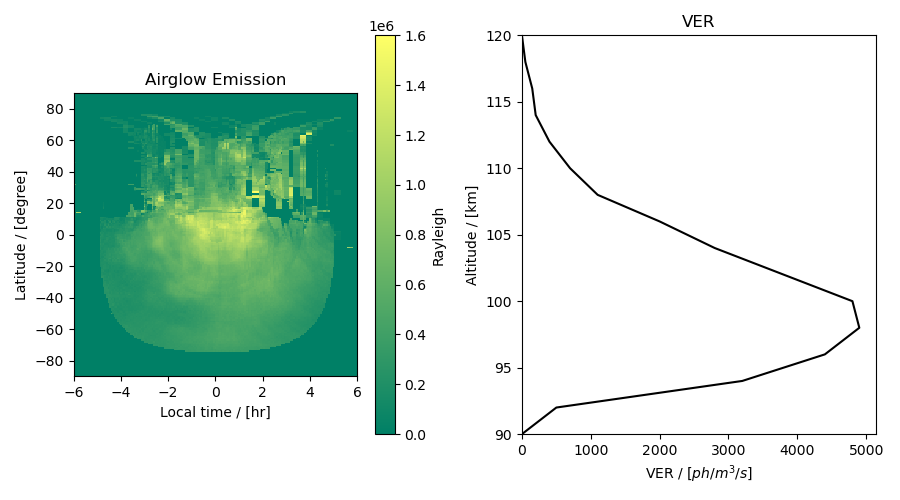

In [10]:
dat = np.genfromtxt(file5) ### Rough VER for 1.27 micro m
mat1 = io.loadmat(file1)  ### VER with latitude/localtime

fig3, (axa, axb) = plt.subplots(1,2,figsize=(9,5)) 
axb.plot(dat[:,1],dat[:,0], c="k")
###
dat = mat1["TEMP"].T
print(dat.shape)
pcm = axa.pcolormesh(np.linspace(-6,6,dat.shape[0]), np.linspace(-90,90,dat.shape[1]), dat,  cmap="summer")
fig3.colorbar(pcm, ax=axa, label="Rayleigh")
###
axa.set_ylabel("Latitude / [degree]")
axa.set_xlabel("Local time / [hr]")
axa.set_title("Airglow Emission")
axa.set_xlim(-6,6)
axa.set_ylim(-90,90)
axa.set_aspect(12/180)
###
axb.set_ylabel("Altitude / [km]")
axb.set_xlabel("VER / [$ph/m^3/s$]")
axb.set_xlim(0,None)
axb.set_ylim(90,120)
axb.set_title("VER")
fig3.tight_layout()
plt.show()

### Amplification and attenuation data
We plot attenuation and amplification as provided in the "alpha_venus.csv" file

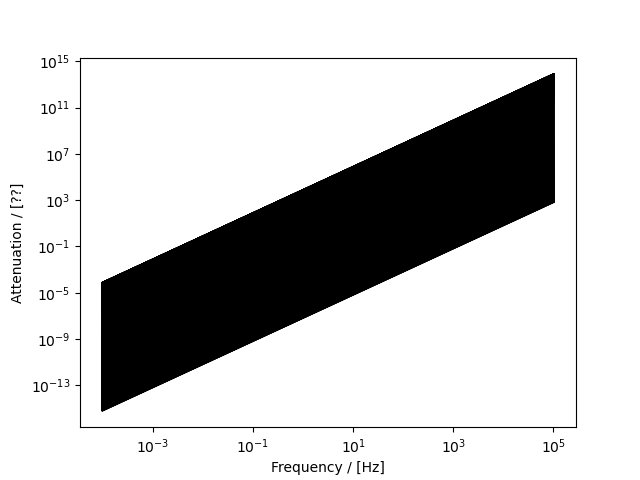

In [14]:
### Amplification of the ground waveform calculated with normal modes ???
mat4 = io.loadmat(file4)

fig2, ax2 = plt.subplots()
for i in range(800) :
    ax2.plot(mat4["f"][0,:], mat4["alpha"][:,i], c="k") 
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Frequency / [Hz]")
ax2.set_ylabel("Attenuation / [??]")
plt.show()

### Amplification and attenuation data
We plot attenuation and amplification as provided in the "attenuation_kenda.csv" file.

Unit of attenuation is not clear, but might be Np/km.

/tmp/ipykernel_63086/4151037659.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (axa, axb) = plt.subplots(1,2, figsize=(8,4))
/tmp/ipykernel_63086/4151037659.py:41: RuntimeWarning: divide by zero encountered in log10
  axb.pcolormesh(f_test, z_test, np.log10(RES), cmap="viridis", vmin = np.log10(alpha.min()), vmax = np.log10(alpha.max()))


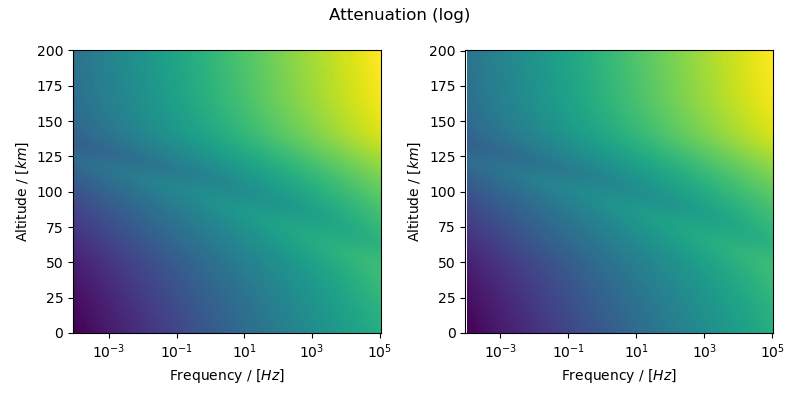

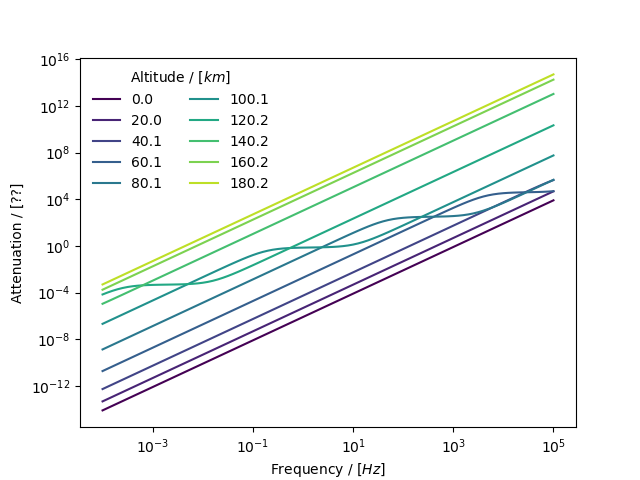

In [19]:
atten = pd.read_csv('./data/attenuation_kenda.csv', header=[0])
alts = atten.alt.unique()
freq = atten.frequency.unique()
FF, AA = np.meshgrid(freq, alts)


### There are 800 altitudes and 91 frequencies
alpha = atten.alpha.values.reshape((alts.size, freq.size))

##############################################################################
fig2, ax2 = plt.subplots()
cols = plt.get_cmap("viridis")
for i in range(0,800,80) :
    ax2.plot(freq, alpha[i,:], c=cols(i/799), label = "{:.1f}".format(alts[i])) 
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.legend(title="Altitude / [$km$]", ncol=2, framealpha=0.5, edgecolor="none")
ax2.set_xlabel("Frequency / [$Hz$]")
ax2.set_ylabel("Attenuation / [??]")
##############################################################################
### Function giving alpha at all frequency given an altitude 
# f_alpha = interpolate.interp1d(freq, alpha, axis=1, bounds_error=False, fill_value=0.0)
### 2D interpolation 
f_alpha_2d = interpolate.RegularGridInterpolator((alts,freq), alpha, method='linear',fill_value=0, bounds_error=False)


##############################################################################
### TEST OF INTERPOLATION 
fig, (axa, axb) = plt.subplots(1,2, figsize=(8,4))
###
axa.pcolormesh(freq, alts, np.log10(alpha), cmap="viridis", vmin = np.log10(alpha.min()), vmax = np.log10(alpha.max()))
axa.set_xscale("log")
axa.set_ylabel("Altitude / [$km$]")
axa.set_xlabel("Frequency / [$Hz$]")
###
### Same thing, but using 2d-interpolated results
f_test = 10**np.linspace(np.log10(freq.min()), np.log10(freq.max()), 200)
z_test = np.linspace(0, alts.max(), 400)
FF, ZZ = np.meshgrid(f_test, z_test)
RES = f_alpha_2d((ZZ,FF)) 
axb.pcolormesh(f_test, z_test, np.log10(RES), cmap="viridis", vmin = np.log10(alpha.min()), vmax = np.log10(alpha.max()))
axb.set_xscale("log")
axb.set_ylabel("Altitude / [$km$]")
axb.set_xlabel("Frequency / [$Hz$]")
fig.suptitle("Attenuation (log)")
fig.tight_layout()
plt.show()

In [ ]:
### There are 800 altitudes and 91 frequencies
### However the amplification gives the same value at all frequency (only depends on altitude of popagation)
amplification = atten.amplification.values.reshape((alts.size, freq.size))

##############################################################################
fig2, (ax2, ax2b) = plt.subplots(1,2,figsize=(8,4))
for i in range(0,800,80) :
    ax2.plot(freq, amplification[i,:], c=cols(i/799), label = "{:.1f}".format(alts[i])) 
# for i in range(freq.size):  ### useless
#     ax2b.plot(alts, amplification[:,i], c=cols(i/(freq.size-1)), label = "{:.1f}".format(freq[i])) 
ax2b.plot(alts, amplification[:,0], c="k")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2b.set_yscale("log")
ax2.legend(title="Altitude / [$km$]", ncol=2, framealpha=0.5, edgecolor="none")
# ax2b.legend(title="Frequency / [$Hz$]", ncol=2, framealpha=0.5, edgecolor="none")
ax2.set_xlabel("Frequency / [$Hz$]")
ax2b.set_xlabel("Altitude / [$km$]")
ax2.set_ylabel("Amplification / [??]")
ax2b.set_ylabel("Amplification / [??]")
fig2.suptitle("Amplification with altitude")
fig2.tight_layout()
#f_amplification = interpolate.interp1d(freq, amplification, kind='quadratic', axis=1, bounds_error=False, fill_value=0.0)
##############################################################################
### Function giving alpha at all altitudes
f_amplification = interpolate.interp1d(alts, amplification[:,0], kind='quadratic')